In [1]:
# import modules libraries in this section:
import pyodbc
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
# auto-switching between my home SQL server and laptop's SQL express db
try:
    conn = pyodbc.connect(r'Driver={SQL Server};Server=MEDIASERVER;Database=skytrax;Trusted_Connection=yes;')
    cursor = conn.cursor()

except:
    conn = pyodbc.connect(r'Driver={SQL Server};Server=localhost\SQLEXPRESS;Database=skytrax;Trusted_Connection=yes;')
    cursor = conn.cursor()

In [3]:
# select statement to read data from SQL server into pandas dataframe:
query_airline = "SELECT * FROM [skytrax].[dbo].[airline]"
air = pd.read_sql(query_airline, conn)

In [4]:
air.head()

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,None,None,Economy,None,7.0,4.0,4.0,4.0,0.0,None,None,4.0,True
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,None,None,Business Class,None,10.0,4.0,5.0,4.0,1.0,None,None,5.0,True
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,None,None,Economy,None,9.0,5.0,5.0,4.0,0.0,None,None,5.0,True
3,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan,Singapore,2014-09-06,Adria serves this 100 min flight from Ljubljan...,None,None,Business Class,None,8.0,4.0,4.0,3.0,1.0,None,None,4.0,True
4,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,L James,Poland,2014-06-16,WAW-SKJ Economy. No free snacks or drinks on t...,None,None,Economy,None,4.0,4.0,2.0,1.0,2.0,None,None,2.0,False


In [5]:
df = air
print(df.shape,'\n')
print(df.columns,'\n')
print(df.dtypes,'\n')
print(df.describe(),'\n')

(41396, 20) 

Index(['airline_name', 'link', 'title', 'author', 'author_country', 'date',
       'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route',
       'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'ground_service_rating', 'wifi_connectivity_rating',
       'value_money_rating', 'recommended'],
      dtype='object') 

airline_name                      object
link                              object
title                             object
author                            object
author_country                    object
date                              object
content                           object
aircraft                          object
type_traveller                    object
cabin_flown                       object
route                             object
overall_rating                   float64
seat_comfort_rating              float64
cabin_staff_rating               float64


-----

##### EDA 1 - Imputing missing values, dummy-coding columns, dropna to drop null values row, drop duplicates if any, drop irrelevant features

In [6]:
# Identify null values 
df.isnull().sum()

airline_name                         0
link                                 0
title                                0
author                               0
author_country                    1591
date                                 0
content                              0
aircraft                         40118
type_traveller                   39018
cabin_flown                       2876
route                            39055
overall_rating                    4535
seat_comfort_rating               7690
cabin_staff_rating                7688
food_beverages_rating             8132
inflight_entertainment_rating    10282
ground_service_rating            39193
wifi_connectivity_rating         40831
value_money_rating                1673
recommended                          0
dtype: int64

In [7]:
# Impute median 5.5 as a neutral score for empty rating ranging from 1-10.
df['overall_rating'].fillna(5.5,inplace=True)

# Impute median 3 as a neutral score for empty rating ranging from 1-5. 
df['seat_comfort_rating'].fillna(3.0,inplace=True)
df['cabin_staff_rating'].fillna(3.0,inplace=True)
df['food_beverages_rating'].fillna(3.0,inplace=True) 
df['inflight_entertainment_rating'].fillna(3.0,inplace=True)
df['ground_service_rating'].fillna(3.0,inplace=True)
df['wifi_connectivity_rating'].fillna(3.0,inplace=True)
df['value_money_rating'].fillna(3.0,inplace=True)          

In [8]:
# change recommended value from True or False to 1 or 0 
df_recomm = pd.get_dummies(df['recommended'], drop_first=True)
df_recomm.columns = ['recommend']

In [9]:
# concatenate all 3 dataframes together
df = pd.concat([df, df_recomm], axis=1)

In [10]:
# drop irrelevant columns and featured columns that had been dummy-coded. 
df.drop(columns=['link','title','author','date','aircraft','type_traveller','route','recommended'],axis=1,inplace=True)

In [11]:
# drops any row with null/Nan values as well as drops any duplicate (if exist)
df.dropna(inplace=True)
df.drop_duplicates() 

,airline_name,author_country,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommend
0,adria-airways,Germany,Outbound flight FRA/PRN A319. 2 hours 10 min f...,Economy,7.0,4.0,4.0,4.0,0.0,3,3,4.0,1
1,adria-airways,United States,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,Business Class,10.0,4.0,5.0,4.0,1.0,3,3,5.0,1
2,adria-airways,Switzerland,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,Economy,9.0,5.0,5.0,4.0,0.0,3,3,5.0,1
3,adria-airways,Singapore,Adria serves this 100 min flight from Ljubljan...,Business Class,8.0,4.0,4.0,3.0,1.0,3,3,4.0,1
4,adria-airways,Poland,WAW-SKJ Economy. No free snacks or drinks on t...,Economy,4.0,4.0,2.0,1.0,2.0,3,3,2.0,0
5,adria-airways,Germany,Sarajevo-Frankfurt via Ljubljana. I loved flyi...,Economy,9.0,4.0,4.0,3.0,3.0,3,3,4.0,1
6,adria-airways,France,I had flights from Paris to Sarajevo via Ljubl...,Economy,5.0,4.0,4.0,1.0,0.0,3,3,3.0,1
7,adria-airways,Slovenia,LJU to FRA and back both flights were on time....,Economy,9.0,5.0,5.0,4.0,3.0,3,3,4.0,1
8,adria-airways,Singapore,On my Ljubljana - Munich flight in business cl...,Business Class,8.0,4.0,3.0,4.0,1.0,3,3,4.0,1
9,adria-airways,Slovenia,Flights from LJU to ZRH and back all on time. ...,Economy,10.0,5.0,5.0,4.0,4.0,3,3,4.0,1


In [12]:
df['ground_service_rating'] = df['ground_service_rating'].astype('float')
df['wifi_connectivity_rating'] = df['wifi_connectivity_rating'].astype('float')

In [13]:
print(df.columns)
print(df.isnull().sum())
df.shape

Index(['airline_name', 'author_country', 'content', 'cabin_flown',
       'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'ground_service_rating', 'wifi_connectivity_rating',
       'value_money_rating', 'recommend'],
      dtype='object')
airline_name                     0
author_country                   0
content                          0
cabin_flown                      0
overall_rating                   0
seat_comfort_rating              0
cabin_staff_rating               0
food_beverages_rating            0
inflight_entertainment_rating    0
ground_service_rating            0
wifi_connectivity_rating         0
value_money_rating               0
recommend                        0
dtype: int64


(38466, 13)

In [14]:
df.dtypes

airline_name                      object
author_country                    object
content                           object
cabin_flown                       object
overall_rating                   float64
seat_comfort_rating              float64
cabin_staff_rating               float64
food_beverages_rating            float64
inflight_entertainment_rating    float64
ground_service_rating            float64
wifi_connectivity_rating         float64
value_money_rating               float64
recommend                          uint8
dtype: object

In [15]:
labelencoder = LabelEncoder()
df['author_country'] = labelencoder.fit_transform(df['author_country'])

In [16]:
df['airline'] = df['airline_name']
labelencoder = LabelEncoder()
df['airline_name'] = labelencoder.fit_transform(df['airline_name'])

In [22]:
df['cabin_class'] = df['cabin_flown']
# create dummy-coded columns for cabin class types
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['cabin_flown'] = labelencoder.fit_transform(df['cabin_flown'])

In [23]:
df['cabin_class'].value_counts()

Economy            29740
Business Class      6337
Premium Economy     1510
First Class          879
Name: cabin_class, dtype: int64

In [24]:
df['cabin_flown'].value_counts()

1    29740
0     6337
3     1510
2      879
Name: cabin_flown, dtype: int64

----

#### EDA 2 - Distribution analysis, correlation analysis, data sanity check, identify outlier

In [ ]:
# define a method for charting a correlation heat map: 

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(11,7))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

In [ ]:
correlation_heat_map(air)

##### Strong correlation is observed between "Overall Rating", "Value Money Rating" and "Recommended". 

##### There is no multicollinearity between independent variables. We can use these various variables for predicting "Overall Rating" or "Recommended"

----
##### Investigate various ratings features by grouping airlines

In [26]:
features = 'airline','overall_rating','seat_comfort_rating','cabin_staff_rating','food_beverages_rating','inflight_entertainment_rating','value_money_rating'

# subset 1 is to find the number of reviews for each airline.
df_overall_1 = df.groupby('airline')[features].count().sort_values(by=['overall_rating'],ascending=False) 

# subset 2 is to find the average rating for each airline.
df_overall_2 = df.groupby('airline')[features].mean().sort_values(by=['overall_rating'],ascending=False)

# Concat both subsets together 
df_overall = pd.concat([df_overall_1, df_overall_2], axis=1)

In [27]:
# First column is the nos of reviews per airlines. 
df_overall = df_overall.iloc[:,6:]
df_overall.columns = ['total_reviewed', 'overall_rating','seat_comfort_rating','cabin_staff_rating','food_beverages_rating','inflight_entertainment_rating','value_money_rating']
df_overall.head()

,total_reviewed,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating
adria-airways,31,7.290323,3.548387,3.645161,3.161290,2.096774,3.354839
aegean-airlines,238,7.716387,3.609244,3.886555,3.466387,2.138655,3.726891
aer-lingus,416,7.147837,3.391827,3.586538,2.968750,2.271635,3.598558
aerocaribbean,1,8.000000,3.000000,3.000000,3.000000,3.000000,4.000000
aeroflot-russian-airlines,248,6.677419,3.431452,3.439516,3.383065,3.012097,3.830645


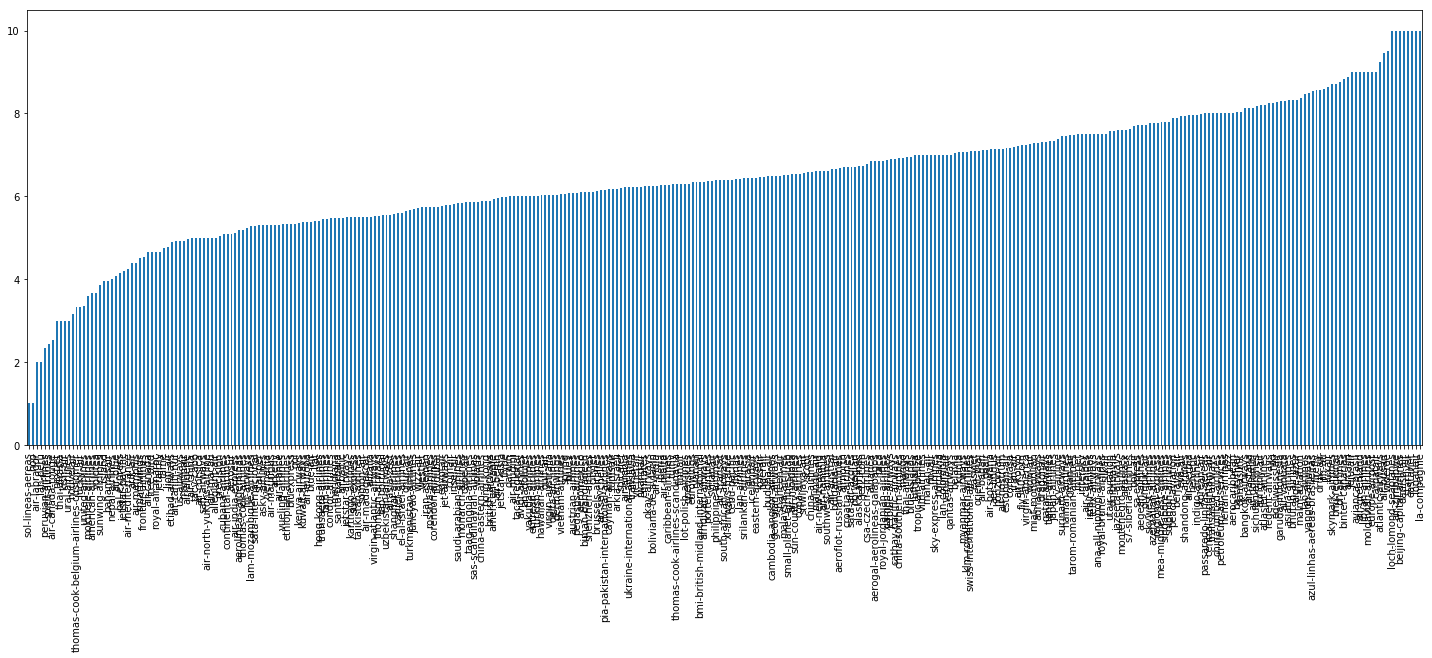

In [28]:
# Overall rating data looks good as it is not imbalanced because the data is ranged evenly from minimum rating of 1 to maximum of 10.

df_overall['overall_rating'].sort_values(ascending=True).plot(kind='bar',figsize=(25,8))

In [30]:
# Excluding airlines that have total number of reviews below 280. 
# Why - This will removes tiny, small, budget, unpopular airlines with few reviews)

df_reviews = df_overall[df_overall['total_reviewed'] > 280]
df_reviews.reset_index(inplace=True)
df_reviews.columns = ['airline', 'total_reviewed', 'overall_rating', 'seat_comfort_rating','cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating', 'value_money_rating']

In [31]:
# Sanity check using data for simple analysis - find top 20 best rated airline by customer reviews.  
top20 = df_reviews[['airline','overall_rating','seat_comfort_rating','cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating','value_money_rating']].sort_values('overall_rating',ascending=False).reset_index().head(20)
top20.drop(columns=['index'],inplace=True)
top20

,airline,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating
0,asiana-airlines,8.330033,3.914191,4.267327,4.033003,3.372937,4.254125
1,garuda-indonesia,8.299716,4.349432,4.477273,4.034091,3.781250,4.315341
2,korean-air,7.976636,3.819315,4.227414,3.595016,3.710280,4.028037
3,eva-air,7.927152,3.860927,4.023179,3.605960,3.612583,4.062914
4,singapore-airlines,7.788863,3.839907,4.357309,4.006961,4.041763,3.932715
5,qatar-airways,7.319106,3.869919,4.077236,3.772358,3.780488,4.174797
6,aer-lingus,7.147837,3.391827,3.586538,2.968750,2.271635,3.598558
7,easyjet,7.098434,3.295302,3.527964,2.355705,2.986577,3.666667
8,swiss-international-air-lines,7.095238,3.497024,3.851190,3.580357,2.738095,3.577381
9,klm-royal-dutch-airlines,7.074324,3.383784,3.978378,3.559459,3.075676,3.629730


##### Top Rated Airlines (Overall Rating vs Value Money Rating)

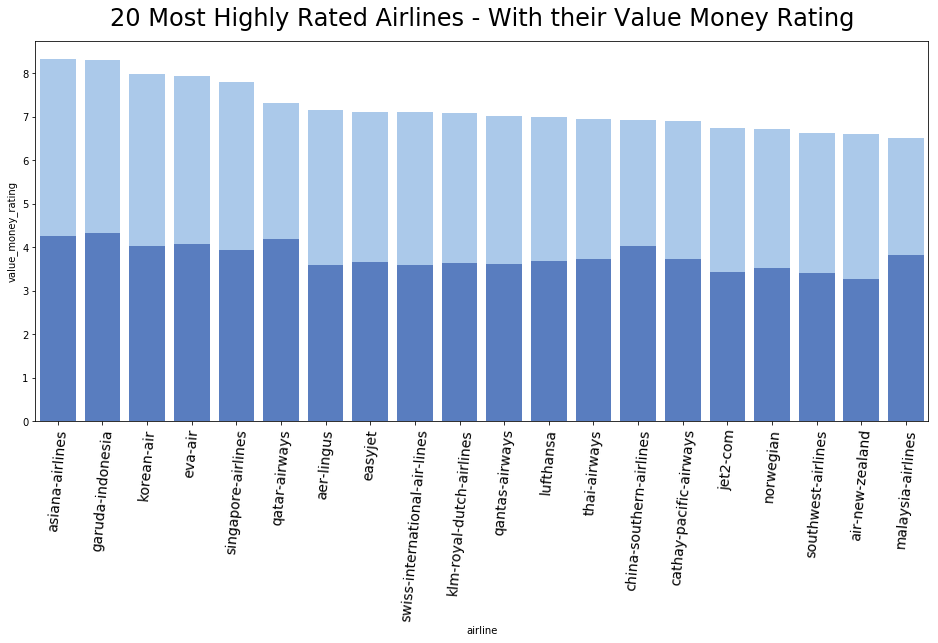

In [33]:
f, ax = plt.subplots(1,1,figsize=(16,7))
sns.set_color_codes("pastel")

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=85)
ax.set_title('20 Most Highly Rated Airlines - With their Value Money Rating',fontdict={'fontsize':24},pad=15)

sns.barplot(x=top20.airline,y=top20.overall_rating,data=top20, color="b")
sns.set_color_codes("muted")
sns.barplot(x=top20.airline,y=top20.value_money_rating,data=top20, color="b")

In [34]:
# Excluding airlines that have total number of reviews below 100. 
# Why - This will removes tiny, small, budget, unpopular airlines with few reviews)

df_reviews = df_overall[df_overall['total_reviewed'] > 100]
df_reviews.reset_index(inplace=True)
df_reviews.columns = ['airline', 'total_reviewed', 'overall_rating', 'seat_comfort_rating','cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating', 'value_money_rating']

In [35]:
# Sanity check using data for simple analysis - find top 20 best rated airline by customer reviews.  
btm20 = df_reviews[['airline','overall_rating','seat_comfort_rating','cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating','value_money_rating']].sort_values('overall_rating',ascending=False).reset_index().tail(20)
btm20.drop(columns=['index'],inplace=True)
btm20

,airline,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,value_money_rating
89,ethiopian-airlines,5.332500,3.020000,3.275000,3.160000,2.385000,3.010000
90,vueling-airlines,5.325581,2.588040,2.714286,2.102990,1.627907,2.461794
91,air-france,5.313131,2.898990,3.280303,3.000000,2.881313,3.106061
92,air-mauritius,5.300926,2.546296,3.018519,2.870370,2.648148,2.759259
93,fiji-airways,5.228261,2.940217,3.125000,2.375000,2.336957,2.777174
94,thomas-cook-airlines,5.185366,2.409756,3.160976,2.697561,1.843902,2.658537
95,aerolineas-argentinas,5.180233,2.959302,2.848837,2.691860,2.058140,2.755814
96,continental-airlines,5.100000,3.000000,2.916129,2.916129,2.987097,2.509677
97,allegiant-air,5.004141,2.598344,2.666667,1.530021,0.826087,2.484472
98,air-china,4.989083,3.131004,2.951965,2.615721,2.379913,3.135371


##### Bottom Rated Airlines (Overall Rating vs Value Money Rating)

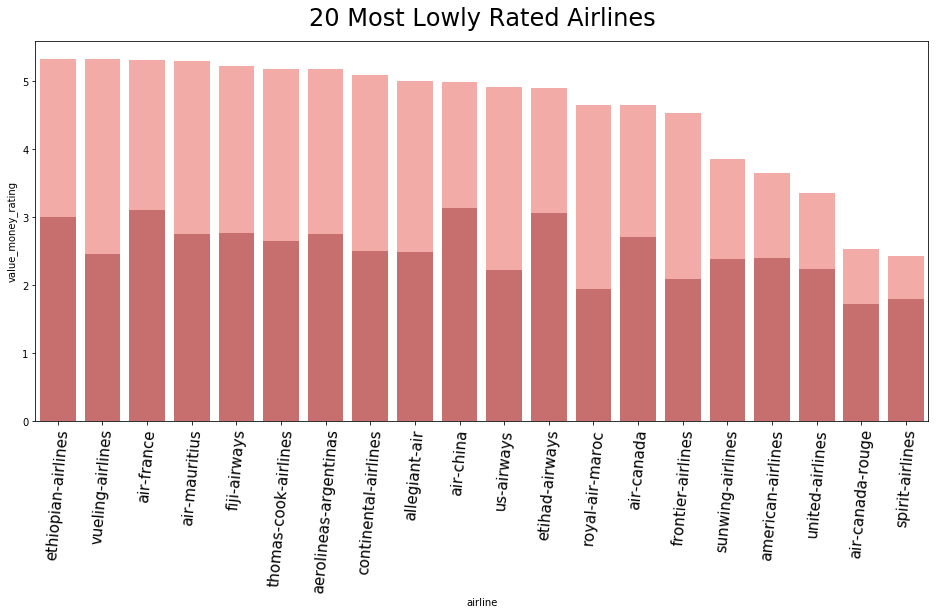

In [36]:
f, ax = plt.subplots(1,1,figsize=(16,7))
sns.set_color_codes("pastel")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=15, rotation=85)
ax.set_title('20 Most Lowly Rated Airlines',fontdict={'fontsize':24},pad=15)

sns.barplot(x=btm20.airline,y=btm20.overall_rating,data=btm20, color="r")
sns.set_color_codes("muted")
sns.barplot(x=btm20.airline,y=btm20.value_money_rating,data=btm20, color="r")

-----

##### Investigate "Recommended" by airlines

In [37]:
# subset 1 is to find the number of reviews for each airline.
df_recommend_1 = df.groupby('airline')['recommend'].count()

# subset 2 is to find the average rating for each airline.
df_recommend_2 = df.groupby('airline')['recommend'].mean()

# Concat both subsets together
df_recommended = pd.concat([df_recommend_1, df_recommend_2], axis=1)

df_recommended.columns = ['total_reviewed','recommended']

In [39]:
# Excluding airlines that have total number of reviews below 305.
df_reviews = df_recommended[df_recommended['total_reviewed'] > 305]
df_reviews.head(10)

,total_reviewed,recommended
airline,,
aer-lingus,416,0.689904
air-canada,490,0.397959
air-canada-rouge,715,0.137063
air-france,396,0.484848
air-india,326,0.588957
air-new-zealand,310,0.596774
air-transat,333,0.573574
alitalia,324,0.435185
allegiant-air,483,0.273292


In [40]:
# Sanity check using data for simple analysis - find "Top 10 Most Recommended Airlines" by reviews.  
top10 = df_reviews.sort_values('recommended',ascending=False).reset_index().head(10)
top10

,airline,total_reviewed,recommended
0,garuda-indonesia,352,0.911932
1,singapore-airlines,431,0.816705
2,lufthansa,599,0.813022
3,korean-air,321,0.791277
4,qatar-airways,492,0.774390
5,thai-airways,360,0.744444
6,china-southern-airlines,411,0.739659
7,qantas-airways,579,0.732297
8,swiss-international-air-lines,336,0.717262
9,klm-royal-dutch-airlines,370,0.702703


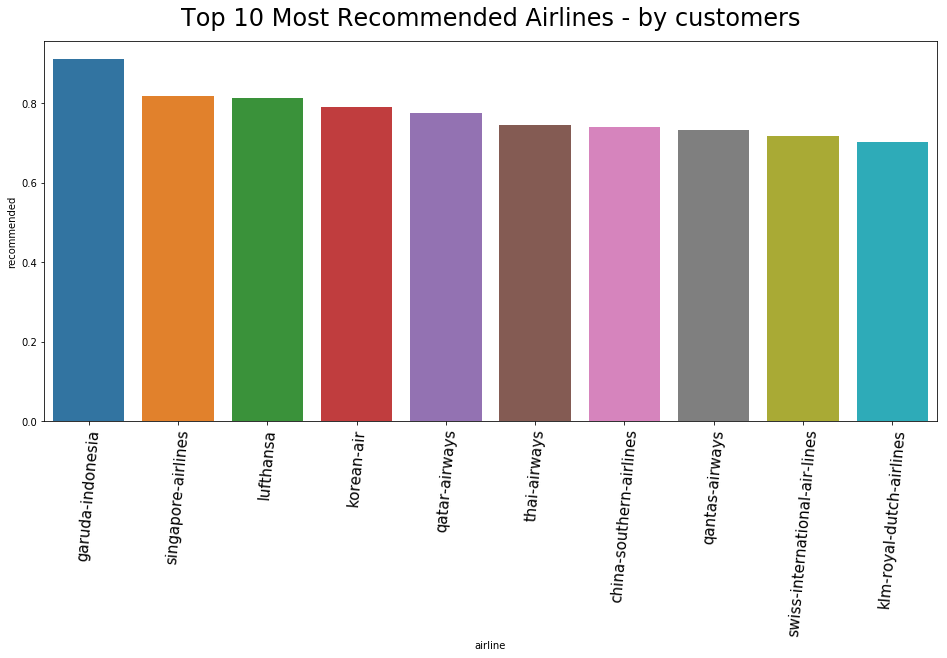

In [41]:
f, ax = plt.subplots(1,1,figsize=(16,7))
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=15, rotation=85)
ax.set_title('Top 10 Most Recommended Airlines - by customers',fontdict={'fontsize':24},pad=15)

sns.barplot(x=top10.airline,y=top10.recommended,data=top10)

##### Overall rating and Recommended charts are almost identical. This is unsurprising because positive reviewer who scored high overall rating would "recommend" the same airline. 

##### Whereas negative reviewer who scored bad overall rating would NOT recommend due to poor experience of their flight experience. 

-----

In [43]:
df['overall'] = df['overall_rating']/2

----
##### Baseline model for regression

In [44]:
df_air = df.groupby('airline_name').mean()

In [45]:
df_air

,author_country,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommend,overall
airline_name,,,,,,,,,,,,
0,109.290323,0.774194,7.290323,3.548387,3.645161,3.161290,2.096774,3.000000,3.000000,3.354839,0.870968,3.645161
1,94.705882,0.890756,7.716387,3.609244,3.886555,3.466387,2.138655,3.058824,2.995798,3.726891,0.789916,3.858193
2,116.790865,0.891827,7.147837,3.391827,3.586538,2.968750,2.271635,3.019231,2.995192,3.598558,0.689904,3.573918
3,39.000000,1.000000,8.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,1.000000,4.000000
4,94.270161,0.887097,6.677419,3.431452,3.439516,3.383065,3.012097,3.020161,3.008065,3.830645,0.701613,3.338710
5,103.307692,0.769231,6.846154,3.230769,3.076923,3.153846,2.846154,3.000000,3.000000,3.307692,0.769231,3.423077
6,66.290698,0.889535,5.180233,2.959302,2.848837,2.691860,2.058140,3.005814,3.000000,2.755814,0.465116,2.590116
7,119.296296,0.807407,6.096296,3.177778,3.125926,3.081481,2.637037,3.051852,3.029630,2.962963,0.511111,3.048148
8,108.600000,1.000000,5.100000,2.400000,3.200000,2.800000,2.200000,3.000000,3.000000,2.000000,0.400000,2.550000


In [46]:
# standardise all rating to scale from 1-10. 
df_air['seat_rating'] = df_air.seat_comfort_rating * 2
df_air['cabin_rating'] = df_air.cabin_staff_rating * 2
df_air['food_rating'] = df_air.food_beverages_rating * 2
df_air['entertain_rating'] = df_air.inflight_entertainment_rating * 2
df_air['value_rating'] = df_air.value_money_rating * 2

# df_air.drop(columns=['seat_comfort_rating','cabin_staff_rating','food_beverages_rating','inflight_entertainment_rating','value_money_rating'],axis=1,inplace=True)

In [47]:
df_air.columns

Index(['author_country', 'cabin_flown', 'overall_rating',
       'seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating', 'ground_service_rating',
       'wifi_connectivity_rating', 'value_money_rating', 'recommend',
       'overall', 'seat_rating', 'cabin_rating', 'food_rating',
       'entertain_rating', 'value_rating'],
      dtype='object')

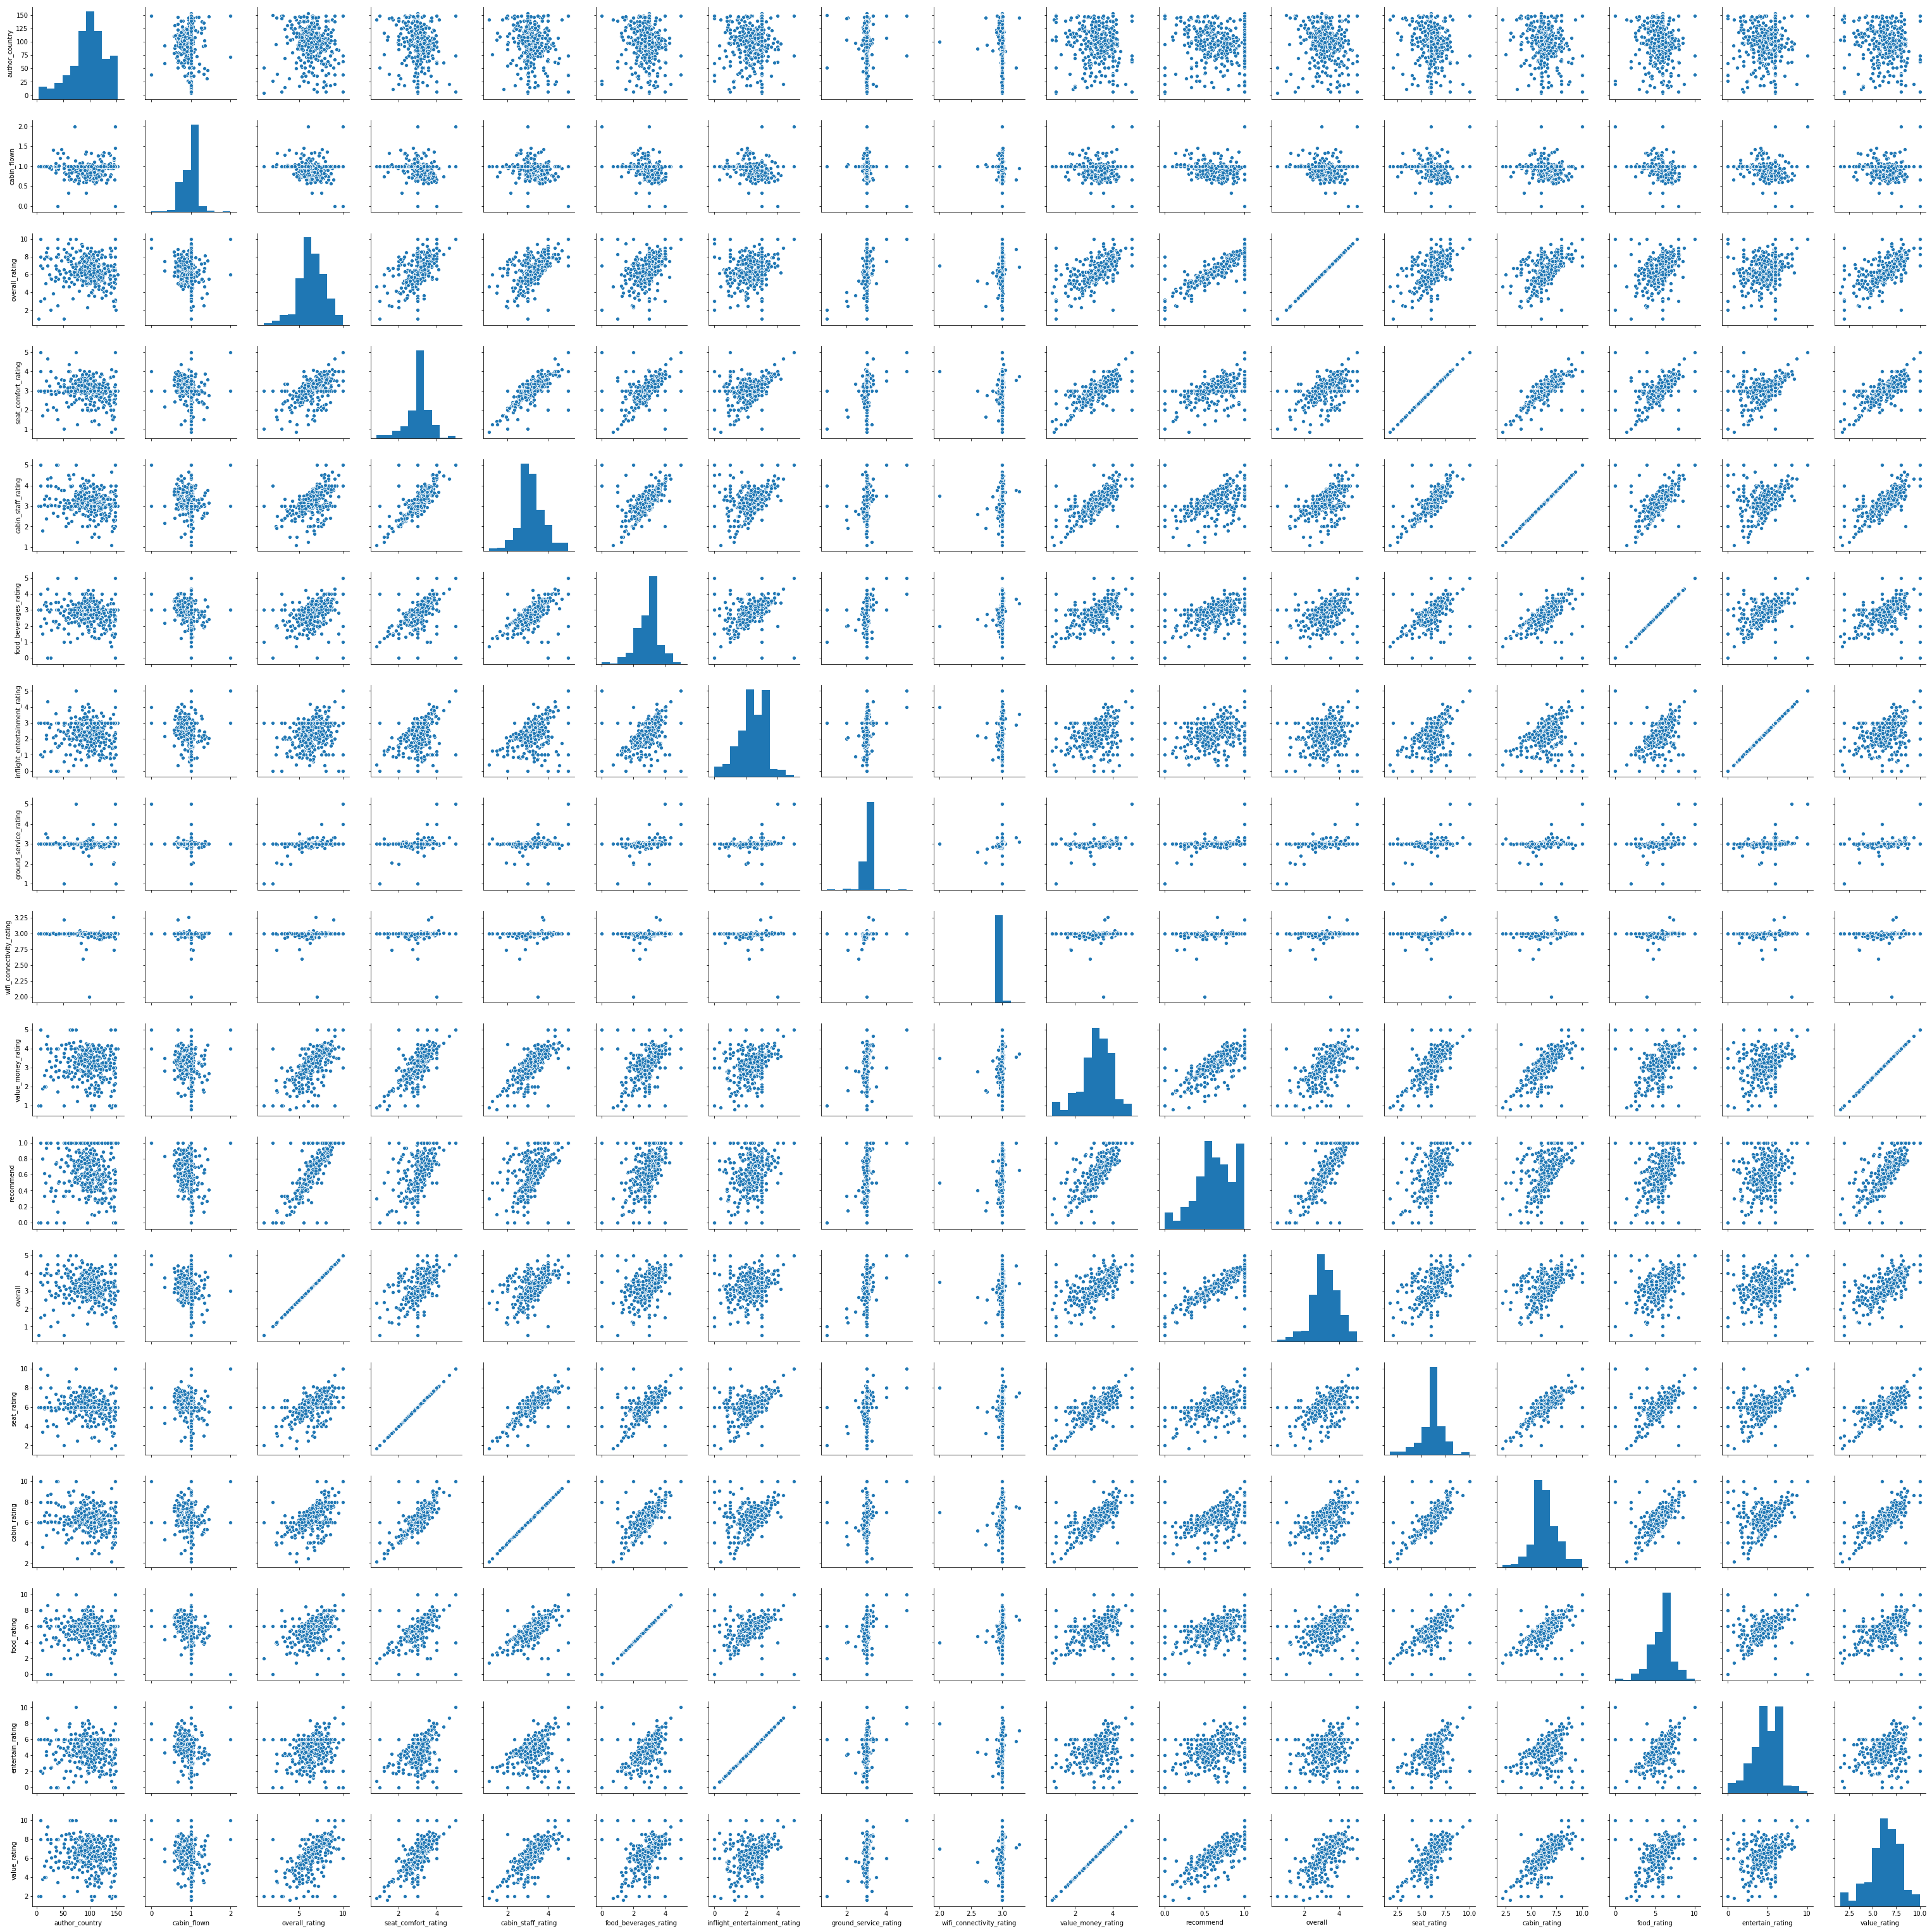

In [48]:
sns.pairplot(df_air)

In [49]:
X = df_air[['seat_rating', 'cabin_rating', 'food_rating',
       'entertain_rating', 'value_rating']].values
# manually add the intercept column:
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
y = df_air['overall_rating'].values

In [50]:
print(X.shape)
print(y.shape)

(351, 6)
(351,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(175, 6)
(175,)
(176, 6)
(176,)


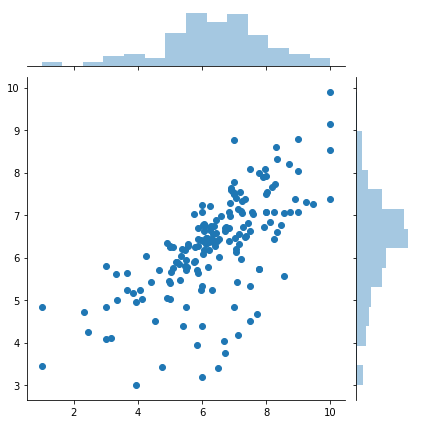

In [52]:
# Create the model with train dataset
model = sm.OLS(y_train, X_train)
model = model.fit()

y_test_pred = model.predict(X_test)

sns.jointplot(y_test, y_test_pred)

In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     25.33
Date:                Sun, 10 Mar 2019   Prob (F-statistic):           5.15e-19
Time:                        14:41:00   Log-Likelihood:                -262.17
No. Observations:                 175   AIC:                             536.3
Df Residuals:                     169   BIC:                             555.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1621      0.143      1.133      0.259      -0.120       0.445
x2             0.1451      0.127      1.140      0.256      -0.106       0.396
x3             0.1859      0.068      2.725      0.007       0.051       0.321
x4             0.0308      0.052      0.590      0.556      -0.072       0.134
x5             0.3711      0.072      5.157      0.000       0.229       0.513
const          0.9496      0.561      1.692      0.093      -0.159       2.058
==============================================================================
Omnibus:                       15.214   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.411
Skew:                           0.298   Prob(JB):                     1.24e-08
Kurtosis:                       5.153   Cond. No.                         92.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
df_air = df_air.reset_index()

##### Staging area - data preparation for modelling purposes

In [58]:
# define budget airlines data subset
budget = df[df['airline'].isin(['airasia-x','airasia','airasia-zest','air-algerie','air-botswana','air-arabia',\
        'air-malawi','fly540-com','royal-air-maroc','taag-angola-airlines','thai-airasia','tigerair','air-namibia','sa-express',\
        'libyan-airlines','mango','kulula','nouvelair','spring','lam-mozambique-airlines','spicejet','hong-kong','regional-express',\
        'indigo-airlines','goair','jetstar-airways','jetstar-asia','jetstar-pacific','air-india-express','lion-air',\
        'peach-aviation','sky-express-airlines','skymark-airlines','starflyer','vanilla-air','eastarjet','jeju-air',\
        'jin-air','lao-airlines','firefly','malindo-air','cebu-pacific','pal-express','scoot','nok-air','orient-thai',\
        'vietjetair','pia-pakistan-international-airlines','smartwings','transavia','germanwings','wizz-air','wow-air',\
        'ryanair','blue-panorama-airlines','blue-air','bluexpress','volotea','vueling-airlines','easyjet','flybe','jet2-com',\
        'jazeera-airways','pegasus-airlines','sun-express','flydubai','air-transat','sunwing-airlines','westjet',\
        'interjet','volaris','air-transat','allegiant-air','frontier-airlines','jetblue-airways','southwest-airlines',\
        'spirit-airlines','sun-country-airlines','virgin-america','virgin-atlantic-airways','virgin-australia','liat',\
        'azul-linhas-aereas-brasileiras','gol','pal-express','sky-airline','tame','tam-airlines','peruvian-airlines','star-per'
        ])]                                

In [61]:
budget

,airline_name,author_country,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommend,airline,cabin_class,overall
109,51,7,DPS-SIN. Efficient check in and boarding. Flig...,1,8.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0,1,airasia,Economy,4.00
118,59,149,No complaints here. My flight was to Phoenix/M...,1,9.0,4.0,5.0,0.0,0.0,3.0,3.0,5.0,1,allegiant-air,Economy,4.50
130,131,148,This is the 4th Easyjet flight this year flew ...,1,10.0,5.0,5.0,3.0,3.0,3.0,3.0,5.0,1,easyjet,Economy,5.00
172,147,77,I flew with fly540 from to Nairobi to Eldoret ...,1,9.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,1,fly540-com,Economy,4.50
173,146,7,10/8/12 I flew SZB to PEN. It was a short and ...,1,8.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,1,firefly,Economy,4.00
192,148,148,"Delayed on the way to Cardiff, and delayed on ...",1,2.0,2.0,2.0,1.0,3.0,3.0,3.0,1.0,0,flybe,Economy,1.00
193,148,148,Flight cancelled. Changed to another airline t...,1,3.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,0,flybe,Economy,1.50
642,11,154,My flight on 1st June from Algiers to Lisboa ...,1,3.0,1.0,3.0,2.0,3.0,1.0,3.0,2.0,0,air-algerie,Economy,1.50
659,11,51,Lille to Algiers. The flight has been delayed ...,1,8.0,4.0,5.0,5.0,3.0,4.0,3.0,4.0,1,air-algerie,Economy,4.00
660,11,72,ALG-CDG-ALG Dep 14/01/14 Ret 21/01/14. Very ni...,1,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1,air-algerie,Economy,2.00


In [64]:
# define star airline members data subset 
star = df[df['airline'].isin(['adria-airways','aegean-airlines','air-canada','air-china','air-india','air-new-zealand',\
                    'ana-all-nippon-airways','asiana-airlines','austrian-airlines','avianca','brussels-airlines','copa-airlines',\
                    'croatia-airlines','egyptair','ethiopian-airlines','eva-air','lot-polish-airlines','lufthansa',\
                    'sas-scandinavian-airlines','shenzhen-airlines','singapore-airlines','south-african-airways',\
                    'swiss-international-air-lines','tap-portugal','thai-airways','turkish-airlines','united-airlines'\
                    ])]

In [66]:
star

,airline_name,author_country,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommend,airline,cabin_class,overall
0,0,54,Outbound flight FRA/PRN A319. 2 hours 10 min f...,1,7.0,4.0,4.0,4.0,0.0,3.0,3.0,4.0,1,adria-airways,Economy,3.5
1,0,149,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,0,10.0,4.0,5.0,4.0,1.0,3.0,3.0,5.0,1,adria-airways,Business Class,5.0
2,0,138,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,1,9.0,5.0,5.0,4.0,0.0,3.0,3.0,5.0,1,adria-airways,Economy,4.5
3,0,129,Adria serves this 100 min flight from Ljubljan...,0,8.0,4.0,4.0,3.0,1.0,3.0,3.0,4.0,1,adria-airways,Business Class,4.0
4,0,118,WAW-SKJ Economy. No free snacks or drinks on t...,1,4.0,4.0,2.0,1.0,2.0,3.0,3.0,2.0,0,adria-airways,Economy,2.0
5,0,54,Sarajevo-Frankfurt via Ljubljana. I loved flyi...,1,9.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,1,adria-airways,Economy,4.5
6,0,51,I had flights from Paris to Sarajevo via Ljubl...,1,5.0,4.0,4.0,1.0,0.0,3.0,3.0,3.0,1,adria-airways,Economy,2.5
7,0,131,LJU to FRA and back both flights were on time....,1,9.0,5.0,5.0,4.0,3.0,3.0,3.0,4.0,1,adria-airways,Economy,4.5
8,0,129,On my Ljubljana - Munich flight in business cl...,0,8.0,4.0,3.0,4.0,1.0,3.0,3.0,4.0,1,adria-airways,Business Class,4.0
9,0,131,Flights from LJU to ZRH and back all on time. ...,1,10.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,1,adria-airways,Economy,5.0


In [67]:
# define overall rating classification manually using percentile function
per_100 = np.percentile(df_air['overall_rating'], 100)
per_80 = np.percentile(df_air['overall_rating'], 80)
per_60 = np.percentile(df_air['overall_rating'], 60)
per_40 = np.percentile(df_air['overall_rating'], 40)
per_20 = np.percentile(df_air['overall_rating'], 20)

In [68]:
df_rating_excellent = df_air[(df_air['overall_rating'] > per_80) & (df_air['overall_rating'] < per_100)]
df_rating_excellent.sort_values(by=['overall_rating'],ascending=False,inplace=True)
df_rating_good = df_air[(df_air['overall_rating'] > per_60) & (df_air['overall_rating'] < per_80)]
df_rating_good.sort_values(by=['overall_rating'],ascending=False,inplace=True)
df_rating_average = df_air[(df_air['overall_rating'] > per_40) & (df_air['overall_rating'] < per_60)]
df_rating_average.sort_values(by=['overall_rating'],ascending=False,inplace=True)
df_rating_low = df_air[(df_air['overall_rating'] > per_20) & (df_air['overall_rating'] < per_40)]
df_rating_low.sort_values(by=['overall_rating'],ascending=False,inplace=True)
df_rating_bad = df_air[(df_air['overall_rating'] > 1) & (df_air['overall_rating'] < per_20)]
df_rating_bad.sort_values(by=['overall_rating'],ascending=False,inplace=True)

In [70]:
import pickle
fileObject1 = open("df_main.pickle",'wb')
fileObject2 = open("df_air.pickle",'wb')
fileObject3 = open("star.pickle",'wb')
fileObject4 = open("budget.pickle",'wb')

# dump variables' objects into the files for exporting
pickle.dump(df,fileObject1)
pickle.dump(df_air,fileObject2)
pickle.dump(star,fileObject3)
pickle.dump(budget,fileObject4)

fileObject1.close()
fileObject2.close
fileObject3.close()
fileObject4.close()